In [25]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
# Import the ARIMA object
from statsmodels.tsa.arima.model import ARIMA

In [26]:
# Get time series data:
data = pd.read_csv('SteamCharts.csv',low_memory=False)

In [27]:
# Get Perc_Gain and change data to float.
p_gain = data.loc[data['Perc_Gain']==1]
p_pure = p_gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Gain.
gain = data.loc[data['Gain']==1]
gain_pure = gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_pure = avg_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Peak_Players.
peak_players = data.loc[data['Peak_Players']==1]
peak_pure = peak_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Prepare for plotting
p_gain_plot = p_gain.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days','July 2012','August 2012'])
gain_plot= gain.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days','July 2012'])
avg_plot = avg_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
peak_plot = peak_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])

In [28]:
avg_pure

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,723346.52,740927.82,741013.24,743209.66,717803.75,668754.58,613666.69,606850.32,639957.66,625900.81,...,16006.00,15959.89,17372.73,16164.22,14079.39,14134.10,10739.48,16000.75,15475.39,932.57
4,413784.97,390412.76,404832.13,432671.65,422552.32,425904.83,406361.36,408609.78,429717.12,450213.99,...,174835.73,180878.90,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05
8,186110.65,193114.18,198957.52,201247.19,189233.58,179520.26,162585.64,169093.71,192492.61,211700.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,124905.13,126121.06,120982.64,71766.74,64469.75,74957.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,88187.00,88703.56,101230.91,83148.17,82423.51,70304.79,73594.08,68866.24,66943.58,69301.89,...,41942.51,43336.20,43210.75,44255.06,43623.98,42498.53,46978.70,50699.07,61561.37,45566.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50080,1.04,NaN,1.26,NaN,NaN,NaN,NaN,0.36,NaN,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50084,5.44,6.08,6.99,7.93,7.83,5.57,5.32,5.19,5.65,6.32,...,0.55,0.72,0.54,1.09,1.27,0.63,0.40,0.67,0.78,1.37
50088,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50092,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [29]:
avg_players['max'] = avg_pure.max(axis=1)
avg_pure = avg_pure.drop(avg_players.loc[avg_players['max']==0].index)
avg_pure = avg_pure.reset_index(drop=True)
#avg_plot = avg_plot.drop(avg_players.loc[avg_players['max']==0].index)
#peak_plot = peak_plot.drop(avg_players.loc[avg_players['max']==0].index)
#gain_plot = gain_plot.drop(avg_players.loc[avg_players['max']==0].index)
#p_gain_plot = p_gain_plot.drop(avg_players.loc[avg_players['max']==0].index)

avg_players = avg_players.drop(avg_players.loc[avg_players['max']==0].index)
avg_players['mean'] = avg_pure.mean(axis=1)
avg_players = avg_players.reset_index(drop=True)

<ipython-input-29-e0bdb0f116af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_players['max'] = avg_pure.max(axis=1)


In [30]:
df=avg_pure
avg_pure

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,723346.52,740927.82,741013.24,743209.66,717803.75,668754.58,613666.69,606850.32,639957.66,625900.81,...,16006.00,15959.89,17372.73,16164.22,14079.39,14134.10,10739.48,16000.75,15475.39,932.57
1,413784.97,390412.76,404832.13,432671.65,422552.32,425904.83,406361.36,408609.78,429717.12,450213.99,...,174835.73,180878.90,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05
2,186110.65,193114.18,198957.52,201247.19,189233.58,179520.26,162585.64,169093.71,192492.61,211700.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,124905.13,126121.06,120982.64,71766.74,64469.75,74957.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88187.00,88703.56,101230.91,83148.17,82423.51,70304.79,73594.08,68866.24,66943.58,69301.89,...,41942.51,43336.20,43210.75,44255.06,43623.98,42498.53,46978.70,50699.07,61561.37,45566.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10106,1.29,2.42,1.03,1.05,1.27,0.91,1.35,2.42,1.34,4.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10107,NaN,NaN,NaN,0.59,NaN,0.47,0.75,0.56,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108,1.04,NaN,1.26,NaN,NaN,NaN,NaN,0.36,NaN,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

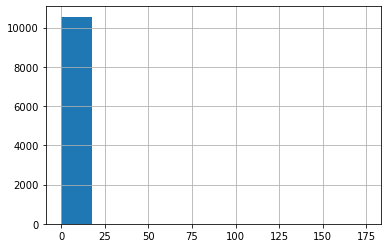

In [31]:
data_all = pd.read_csv('AllData.csv')
data_all['SteamSpyOwners(million))'] = data_all['SteamSpyOwnersNew']/(1e6)

data_all['SteamSpyOwners(million))'].hist()

<AxesSubplot:>

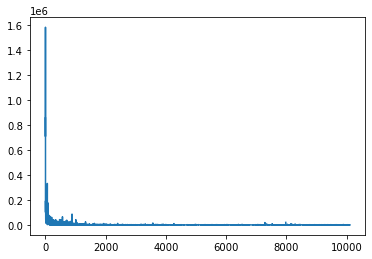

In [32]:
df = avg_players
df['max'].plot()


In [33]:
# Add columns 
birth = [avg_pure.iloc[i].last_valid_index() for i in range(len(avg_pure))]
avg_players['birth'] = birth

avg_players['today'] = datetime(2021, 5,1)
avg_players['to_today'] = ((avg_players.today - avg_players['birth'].astype('datetime64'))/np.timedelta64(1, 'M'))

peak_time = [avg_pure.iloc[i].idxmax(axis=1) for i in range(len(avg_pure))]
avg_players['peak_time'] = peak_time

avg_players['to_peak'] = (avg_players['peak_time'].astype('datetime64')- avg_players['birth'].astype('datetime64'))/np.timedelta64(1, 'M')

peak_value = [avg_players.iloc[i][peak_time[i]] for i in range(len(avg_pure))]
#avg_players['peak_value'] = peak_value
avg_players['peak_value'] = peak_value

KeyError: nan

In [34]:
avg_players['peak_time'].value_counts(ascending=True)[::-1]

April 2021       497
April 2020       480
January 2021     385
February 2021    356
March 2021       341
                ... 
June 2013         21
November 2012     21
May 2013          20
October 2012      19
April 2013        13
Name: peak_time, Length: 106, dtype: int64

In [35]:
avg_players.to_csv('test.csv')


In [36]:
df = avg_plot
df = df.drop(columns=['Name']).reset_index(drop=True)

df.iloc[0].astype(float).values/(1e6)

array([0.72334652, 0.74092782, 0.74101324, 0.74320966, 0.71780375,
       0.66875458, 0.61366669, 0.60685032, 0.63995766, 0.62590081,
       0.67164746, 0.76879525, 0.85760422, 0.67103329, 0.54397915,
       0.501196  , 0.45670156, 0.42608081, 0.40899531, 0.4109256 ,
       0.4150973 , 0.39378283, 0.38937672, 0.36441731, 0.35198992,
       0.39024016, 0.37135896, 0.40136687, 0.39550926, 0.31008543,
       0.32590782, 0.33316399, 0.28353131, 0.27330726, 0.26686224,
       0.26217088, 0.2890767 , 0.35427033, 0.3824571 , 0.38203053,
       0.34087688, 0.3211314 , 0.34186126, 0.35440209, 0.37442569,
       0.37758904, 0.37438804, 0.37182934, 0.39219919, 0.38690872,
       0.40238571, 0.39310953, 0.3421957 , 0.32904526, 0.33307646,
       0.32252589, 0.34722925, 0.35377756, 0.33431106, 0.33873839,
       0.37579587, 0.37942695, 0.37628502, 0.36537109, 0.37744711,
       0.36092588, 0.36276609, 0.35590533, 0.35753524, 0.32953238,
       0.34415601, 0.31728629, 0.29174874, 0.26799631, 0.23993

In [37]:
def plot_games(df, games,title=None, scaling=(1e6)):
    
    df_data = df.drop(columns=['Name']).reset_index(drop=True)
    x = pd.to_datetime(df.columns[1:])
    plt.figure(figsize=(12,12))
    for i in games:
        plt.plot(x,df_data.iloc[i].astype(float).values/scaling,label=df.Name[i])
        plt.legend() 
        plt.title(str(title))
    #plt.vlines(pd.Timestamp(2020,3,1)  ,0,1,colors='k',linestyles='dashed',label='Start of Pandemic')
    #plt.text(pd.Timestamp(2020,3,1))
    plt.show()

April 2021        124905.13
March 2021        126121.06
February 2021     120982.64
January 2021       71766.74
December 2020      64469.75
                    ...    
November 2012           NaN
October 2012            NaN
September 2012          NaN
August 2012             NaN
July 2012               NaN
Name: 3, Length: 106, dtype: float64

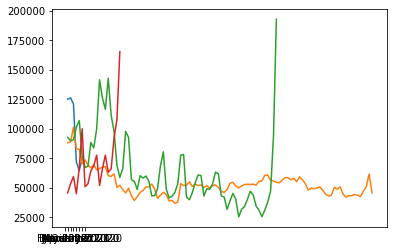

In [38]:
for i in range(3,7):
#    avg_pure.iloc[i] = avg_pure.iloc[i]/
    avg_pure.iloc[i].plot()
#plot_games(avg_plot,[0],title="Avg Players (million) / Day")
avg_pure.iloc[3]

# Naive method for prediction

In [5]:
train=pd.read_csv('Copy_Training_data.csv',index_col=0)
test=pd.read_csv('Copy_Test_data.csv',index_col=0)

In [18]:
test=test.reset_index(drop=True)
test

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,93.35,54.84,27.16,33.46,31.72,31.74,36.32,48.04,39.71,32.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.38,36.50,40.70,40.85,41.81,46.15,50.01,62.20,65.44,64.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26.35,43.95,68.38,41.45,38.84,32.48,36.25,20.81,24.72,39.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29.92,32.16,30.29,33.80,30.33,34.42,47.59,59.48,175.11,371.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5581.76,6220.72,6228.81,5999.86,6115.32,5711.32,7690.21,4925.72,3809.93,3570.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,431.02,494.78,742.09,993.15,853.33,739.11,740.18,1281.86,521.38,834.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,8.55,8.61,8.23,6.89,7.56,12.74,14.69,16.47,8.94,9.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,4.99,5.77,8.21,7.18,8.63,5.21,5.54,5.10,6.50,14.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,10.77,13.46,8.92,8.47,8.50,9.87,9.70,9.35,7.69,13.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
plt.style.use('dark_background')

In [43]:
#Exponential smoothing:

def smooth_plot(data, i_game, smoothing_level=.2,label='Smoothing'):

    game_data = data.drop(columns=['Name']).iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        
    # Use exponential smoothing to predict the last k months
    train = game
    ses = SimpleExpSmoothing(train['Data'].values)
    fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

    plt.figure(figsize=(8,6))
    plt.plot(game.Month,train['Data'],'b',label = "Data")
    plt.plot(game.Month,fit.fittedvalues,'r-',label = "Smoothing")
    
    plt.legend(fontsize=14)
    plt.ylabel(label, fontsize=16)
    plt.title(str(data.Name.iloc[i_game]))
    plt.show()

In [78]:
#Exponential smoothing:

def exp_plot(data, i_game,pred_k=14, smoothing_level=.2,title='Prediction',save_fig=False):

    game_data = data.drop(columns=['Name']).iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        
    # Use exponential smoothing to predict the last k months
    test = game[-pred_k:]
    train = game.drop(test.index)
    ses = SimpleExpSmoothing(train['Data'].values)
    fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

    fig=plt.figure(figsize=(8,6))
    plt.plot(game.Month[:len(game.Month)-pred_k],train['Data'],'m',label = "Training Data")
    plt.plot(game.Month[:len(game.Month)-pred_k],fit.fittedvalues,'y-',label = "Fitted Values")
    
    plt.plot(game.Month[-pred_k:],test['Data'],'m--',label = "Test Data")
    plt.plot(game.Month[-pred_k:],fit.forecast(len(test)),'y--',label = "Forecast")
    
    plt.legend(fontsize=14)
    plt.ylabel(str(data.Name.iloc[i_game]))
    plt.title('Exponential smoothing')
    plt.show()
    
    if save_fig:
        fig.savefig('ExamplePlot2.png',bbox_inches="tight")

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


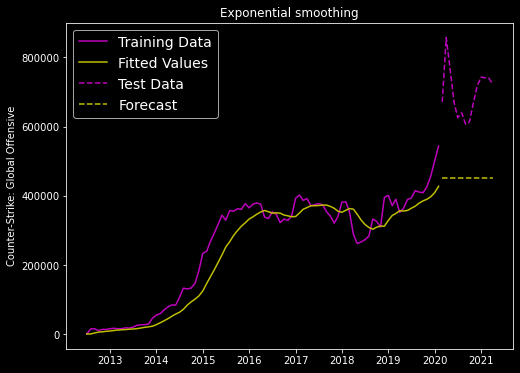

In [80]:
exp_plot(avg_plot,i_game=0,title='Avg_Players',save_fig=True)
#exp_plot(p_gain_plot,i_game=0,title='P_gain')
#exp_plot(peak_plot, i_game=0,title='Peak_Players')
#exp_plot(gain_plot, i_game=0,title='Gain')

In [81]:
def ARIMA_plot(data, i_game,pred_k=14, smoothing_level=.2,order=(1,0,1),scale= 1,title='ARIMA prediction'):

    game_data = data.drop(columns=['Name']).iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
    game.Month[-pred_k:]
        
# Use ARIMA smoothing to predict the last k months
    test = game[-pred_k:]
    train = game.drop(test.index)
    arima = ARIMA(train['Data'], order = order)
    fit = arima.fit()

    plt.figure(figsize=(8,6))
    plt.plot(game.Month[:len(game.Month)-pred_k],train['Data'],'b',label = "Training Data")
    plt.plot(game.Month[:len(game.Month)-pred_k],fit.fittedvalues/scale,'r-',label = "Fitted Values")
    
    plt.plot(game.Month[-pred_k:],test['Data']/scale,'b--',label = "Test Data")
    plt.plot(game.Month[-pred_k:],fit.forecast(len(test))/scale,'r--',label = "Forecast")

    plt.legend(fontsize=14)
    plt.xlabel("Month", fontsize=16)
    plt.ylabel('Number of '+title, fontsize=16)
    plt.title(str(data.Name.iloc[i_game]))
    plt.show()

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


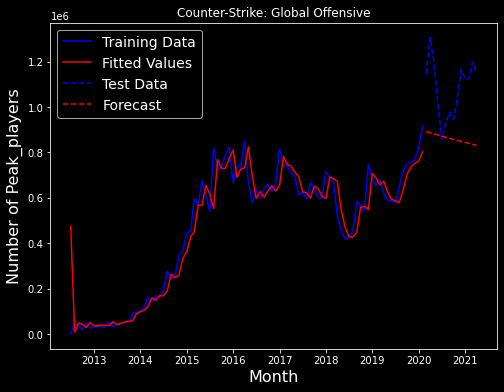

In [83]:
order = (1,0,1)
i = 0

ARIMA_plot(peak_plot, i_game=i,order=order,title='Peak_players')
#ARIMA_plot(avg_plot,i_game=i,order=order,title='Avg_players')
#ARIMA_plot(gain_plot,pred_k=14, i_game=i,order=order,title='Gain')
#ARIMA_plot(p_gain_plot,pred_k=14, i_game=i,order=order,scale=100,title='P_gain')

In [223]:
pred_k=14

game.Month[:106-pred_k]

July 2012        2012-07-01
August 2012      2012-08-01
September 2012   2012-09-01
October 2012     2012-10-01
November 2012    2012-11-01
                    ...    
October 2019     2019-10-01
November 2019    2019-11-01
December 2019    2019-12-01
January 2020     2020-01-01
February 2020    2020-02-01
Name: Month, Length: 92, dtype: datetime64[ns]

In [29]:
game.Month[-pred_k:]

NameError: name 'game' is not defined